# Clasificador CNN para dígitos MNIST (0-9)

Este notebook implementa una red neuronal convolucional para clasificar los 10 dígitos del dataset MNIST.

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import pandas as pd
import random
import os

## 1. Carga del Dataset MNIST

In [5]:
# Cargar el dataset MNIST completo
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Mostrar información sobre el dataset
print(f"Forma de x_train: {x_train.shape}")
print(f"Forma de y_train: {y_train.shape}")
print(f"Forma de x_test: {x_test.shape}")
print(f"Forma de y_test: {y_test.shape}")

# Información de tipos de datos
print(f"\nTipo de datos de x_train: {x_train.dtype}")
print(f"Valor mínimo en x_train: {x_train.min()}")
print(f"Valor máximo en x_train: {x_train.max()}")

Forma de x_train: (60000, 28, 28)
Forma de y_train: (60000,)
Forma de x_test: (10000, 28, 28)
Forma de y_test: (10000,)

Tipo de datos de x_train: uint8
Valor mínimo en x_train: 0
Valor máximo en x_train: 255


## 2. Análisis Exploratorio de Datos (EDA)

### 2.1 Distribución de clases

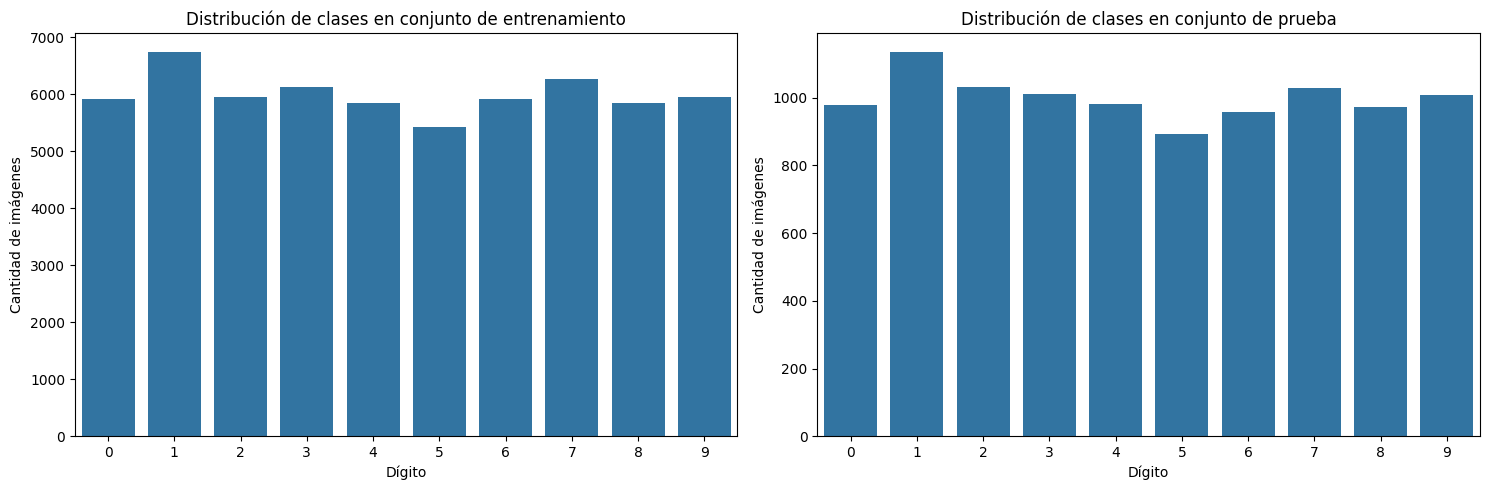

Conteo de cada clase:


,Dígito,Entrenamiento,Prueba,% Entrenamiento,% Prueba
0,0,5923,980,9.87%,9.80%
1,1,6742,1135,11.24%,11.35%
2,2,5958,1032,9.93%,10.32%
3,3,6131,1010,10.22%,10.10%
4,4,5842,982,9.74%,9.82%
5,5,5421,892,9.04%,8.92%
6,6,5918,958,9.86%,9.58%
7,7,6265,1028,10.44%,10.28%
8,8,5851,974,9.75%,9.74%
9,9,5949,1009,9.92%,10.09%


In [6]:
# Analizar la distribución de clases en conjuntos de entrenamiento y prueba
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Distribución en el conjunto de entrenamiento
train_counts = np.bincount(y_train)
sns.barplot(x=list(range(10)), y=train_counts, ax=axes[0])
axes[0].set_title("Distribución de clases en conjunto de entrenamiento")
axes[0].set_xlabel("Dígito")
axes[0].set_ylabel("Cantidad de imágenes")

# Distribución en el conjunto de prueba
test_counts = np.bincount(y_test)
sns.barplot(x=list(range(10)), y=test_counts, ax=axes[1])
axes[1].set_title("Distribución de clases en conjunto de prueba")
axes[1].set_xlabel("Dígito")
axes[1].set_ylabel("Cantidad de imágenes")

plt.tight_layout()
plt.show()

# Mostrar tabla con conteos
print("Conteo de cada clase:")
conteo_df = pd.DataFrame({
    'Dígito': range(10),
    'Entrenamiento': train_counts,
    'Prueba': test_counts,
    '% Entrenamiento': [f"{count/len(y_train)*100:.2f}%" for count in train_counts],
    '% Prueba': [f"{count/len(y_test)*100:.2f}%" for count in test_counts]
})
display(conteo_df)

### 2.2 Visualización de ejemplos de cada clase

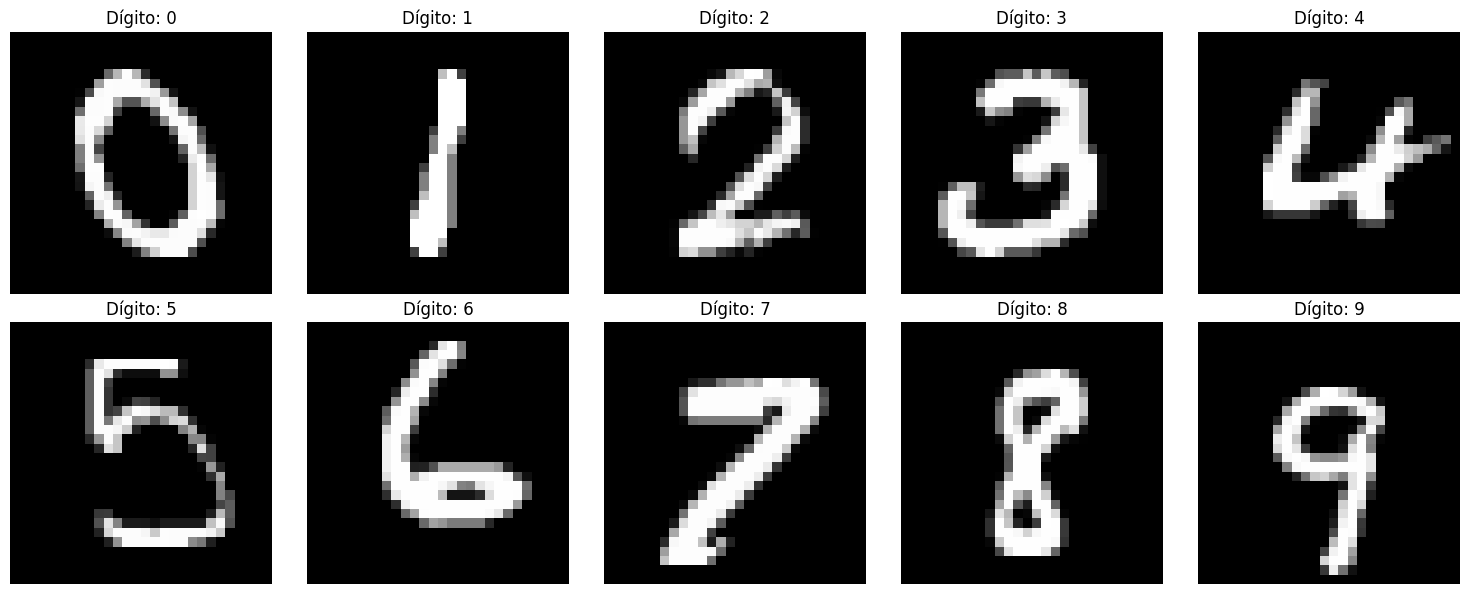

In [7]:
# Visualizar ejemplos de cada dígito
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.flatten()

for i in range(10):
    # Obtener índices de imágenes que representan este dígito
    idxs = np.where(y_train == i)[0]
    
    # Seleccionar un índice aleatorio
    random_idx = random.choice(idxs)
    
    # Mostrar la imagen
    axes[i].imshow(x_train[random_idx], cmap='gray')
    axes[i].set_title(f"Dígito: {i}")
    axes[i].axis('off')

plt.tight_layout()
plt.show()

### 2.3 Análisis de intensidad de píxeles

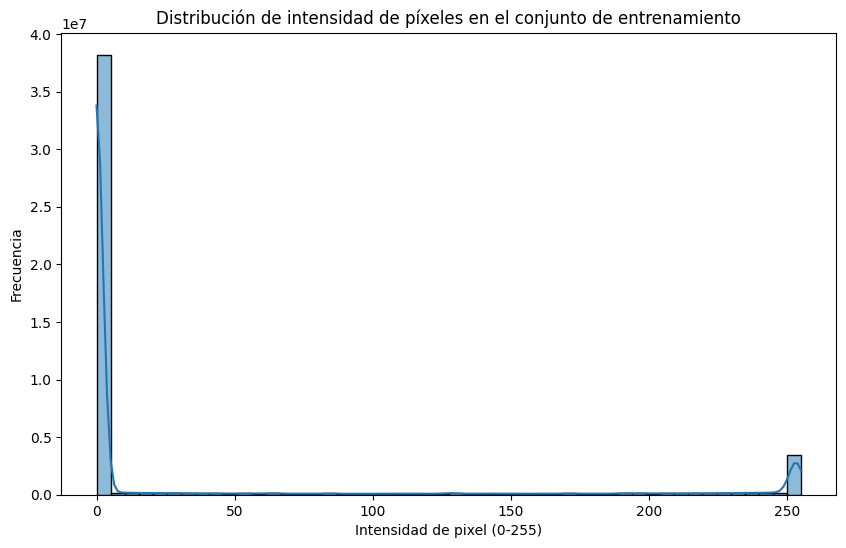

,Dígito,Media,Desviación Estándar,Mínimo,Máximo
0,0.0,44.216828,88.668073,0.0,255.0
1,1.0,19.379654,62.291788,0.0,255.0
2,2.0,37.988658,83.110484,0.0,255.0
3,3.0,36.090187,81.069235,0.0,255.0
4,4.0,30.948226,75.858490,0.0,255.0
5,5.0,32.831095,77.415066,0.0,255.0
6,6.0,35.011953,80.298853,0.0,255.0
7,7.0,29.204563,74.382431,0.0,255.0
8,8.0,38.289775,82.941289,0.0,255.0
9,9.0,31.260435,76.152572,0.0,255.0


In [8]:
# Analizar la distribución de intensidades de píxeles
plt.figure(figsize=(10, 6))
sns.histplot(x_train.flatten(), bins=50, kde=True)
plt.title('Distribución de intensidad de píxeles en el conjunto de entrenamiento')
plt.xlabel('Intensidad de pixel (0-255)')
plt.ylabel('Frecuencia')
plt.show()

# Mostrar estadísticas básicas de intensidad por dígito
stats_df = pd.DataFrame(columns=['Dígito', 'Media', 'Desviación Estándar', 'Mínimo', 'Máximo'])

for i in range(10):
    # Filtrar imágenes de este dígito
    imgs = x_train[y_train == i]
    # Calcular estadísticas
    mean = imgs.mean()
    std = imgs.std()
    min_val = imgs.min()
    max_val = imgs.max()
    
    # Agregar a DataFrame
    stats_df.loc[i] = [i, mean, std, min_val, max_val]

display(stats_df)

### 2.4 Visualización de imágenes con diferentes intensidades

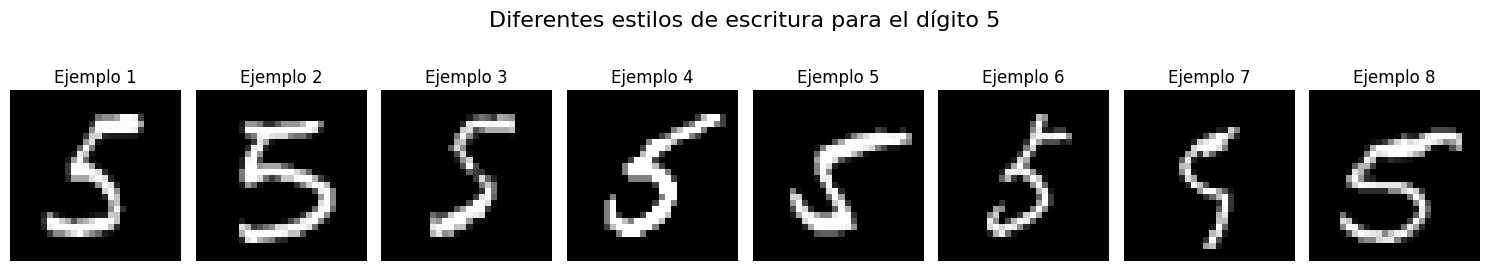

In [9]:
# Mostrar ejemplos de escrituras diferentes del mismo dígito
digit = 5  # Se puede cambiar para ver otros dígitos
num_examples = 8

# Encontrar todas las imágenes del dígito seleccionado
digit_indices = np.where(y_train == digit)[0]

# Seleccionar aleatoriamente algunos ejemplos
selected_indices = np.random.choice(digit_indices, num_examples, replace=False)

# Mostrar los ejemplos
fig, axes = plt.subplots(1, num_examples, figsize=(15, 3))
for i, idx in enumerate(selected_indices):
    axes[i].imshow(x_train[idx], cmap='gray')
    axes[i].set_title(f"Ejemplo {i+1}")
    axes[i].axis('off')

fig.suptitle(f"Diferentes estilos de escritura para el dígito {digit}", fontsize=16)
plt.tight_layout()
plt.subplots_adjust(top=0.8)
plt.show()

## 3. Preprocesamiento de datos

In [10]:
# Preprocesamiento de datos
# x_train = x_train.reshape(60000, 28, 28)  # Resetear a la forma original
# x_test = x_test.reshape(10000, 28, 28)    # Resetear a la forma original

# Normalizar los valores de píxeles [0, 255] → [0.0, 1.0]
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

# Expandir dimensión del canal (para CNN)
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

# Convertir etiquetas a one-hot encoding
y_train_one_hot = to_categorical(y_train, 10)
y_test_one_hot = to_categorical(y_test, 10)

print(f"Forma de x_train después del preprocesamiento: {x_train.shape}")
print(f"Forma de y_train después del preprocesamiento: {y_train_one_hot.shape}")

Forma de x_train después del preprocesamiento: (60000, 28, 28, 1)
Forma de y_train después del preprocesamiento: (60000, 10)


## 4. Definición del modelo CNN

In [11]:
# Definir la arquitectura del modelo
model = models.Sequential([
    layers.Input(shape=(28, 28, 1)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),  # Agregar dropout para reducir overfitting
    layers.Dense(10, activation='softmax')  # 10 clases para los dígitos del 0 al 9
])

# Compilar el modelo
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Resumen del modelo
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 3, 3, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 576)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 130,890 (511.29 KB)

 Trainable params: 130,890 (511.29 KB)

 Non-trainable params: 0 (0.00 B)

## 5. Entrenamiento del modelo

In [12]:
# Entrenar el modelo
history = model.fit(
    x_train, y_train_one_hot,
    epochs=7,  
    batch_size=128,
    validation_split=0.1,  # Usar 10% de los datos de entrenamiento para validación
    verbose=1
)

Epoch 1/7
422/422 ━━━━━━━━━━━━━━━━━━━━ 17s 33ms/step - accuracy: 0.7667 - loss: 0.7242 - val_accuracy: 0.9802 - val_loss: 0.0677
Epoch 2/7
422/422 ━━━━━━━━━━━━━━━━━━━━ 14s 33ms/step - accuracy: 0.9685 - loss: 0.1121 - val_accuracy: 0.9880 - val_loss: 0.0428
Epoch 3/7
422/422 ━━━━━━━━━━━━━━━━━━━━ 13s 31ms/step - accuracy: 0.9793 - loss: 0.0752 - val_accuracy: 0.9887 - val_loss: 0.0379
Epoch 4/7
422/422 ━━━━━━━━━━━━━━━━━━━━ 14s 33ms/step - accuracy: 0.9842 - loss: 0.0542 - val_accuracy: 0.9895 - val_loss: 0.0337
Epoch 5/7
422/422 ━━━━━━━━━━━━━━━━━━━━ 15s 35ms/step - accuracy: 0.9876 - loss: 0.0446 - val_accuracy: 0.9903 - val_loss: 0.0356
Epoch 6/7
422/422 ━━━━━━━━━━━━━━━━━━━━ 14s 34ms/step - accuracy: 0.9887 - loss: 0.0382 - val_accuracy: 0.9907 - val_loss: 0.0331
Epoch 7/7
422/422 ━━━━━━━━━━━━━━━━━━━━ 22s 53ms/step - accuracy: 0.9894 - loss: 0.0336 - val_accuracy: 0.9913 - val_loss: 0.0332


## 6. Visualización del proceso de entrenamiento

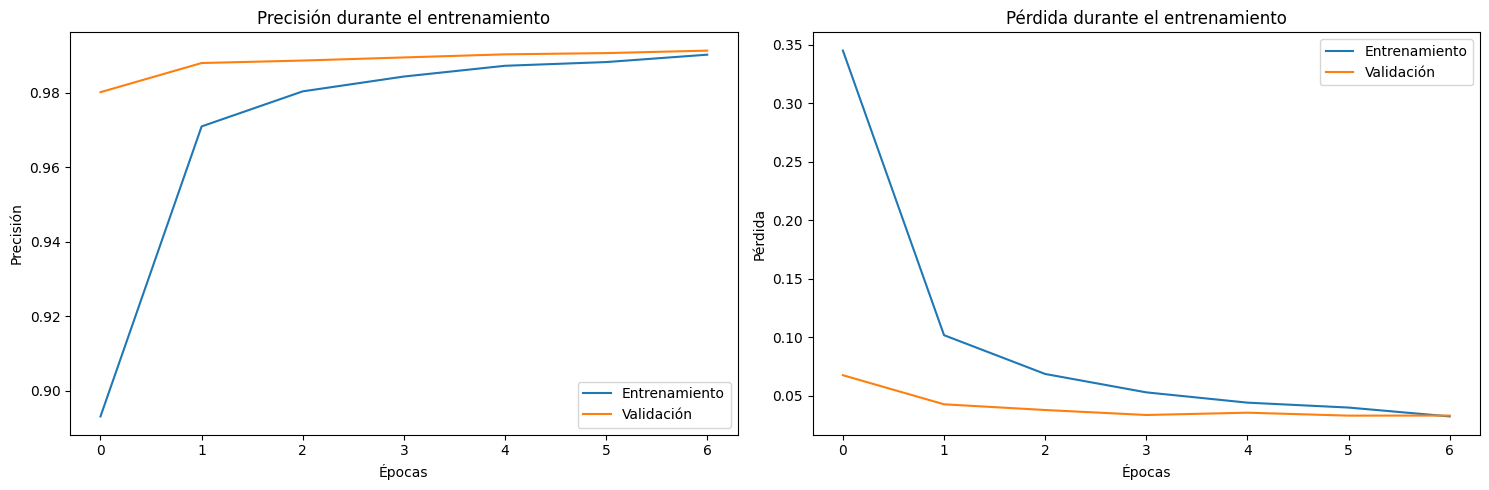

In [13]:
# Visualizar el historial de entrenamiento
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Gráfico de precisión
axes[0].plot(history.history['accuracy'], label='Entrenamiento')
axes[0].plot(history.history['val_accuracy'], label='Validación')
axes[0].set_title('Precisión durante el entrenamiento')
axes[0].set_xlabel('Épocas')
axes[0].set_ylabel('Precisión')
axes[0].legend()

# Gráfico de pérdida
axes[1].plot(history.history['loss'], label='Entrenamiento')
axes[1].plot(history.history['val_loss'], label='Validación')
axes[1].set_title('Pérdida durante el entrenamiento')
axes[1].set_xlabel('Épocas')
axes[1].set_ylabel('Pérdida')
axes[1].legend()

plt.tight_layout()
plt.show()

## 7. Evaluación del modelo

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step


<Figure size 1000x800 with 0 Axes>

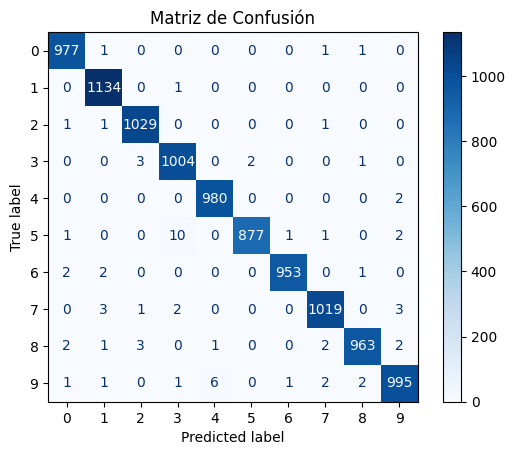

Informe de clasificación:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       980
           1       0.99      1.00      1.00      1135
           2       0.99      1.00      1.00      1032
           3       0.99      0.99      0.99      1010
           4       0.99      1.00      1.00       982
           5       1.00      0.98      0.99       892
           6       1.00      0.99      1.00       958
           7       0.99      0.99      0.99      1028
           8       0.99      0.99      0.99       974
           9       0.99      0.99      0.99      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



In [14]:
# Hacer predicciones en el conjunto de prueba
y_pred_probs = model.predict(x_test)
y_pred = np.argmax(y_pred_probs, axis=1)

# Mostrar matriz de confusión
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(10))
disp.plot(cmap=plt.cm.Blues)
plt.title('Matriz de Confusión')
plt.show()

# Mostrar informe de clasificación
print("Informe de clasificación:")
print(classification_report(y_test, y_pred))

## 8. Visualización de predicciones

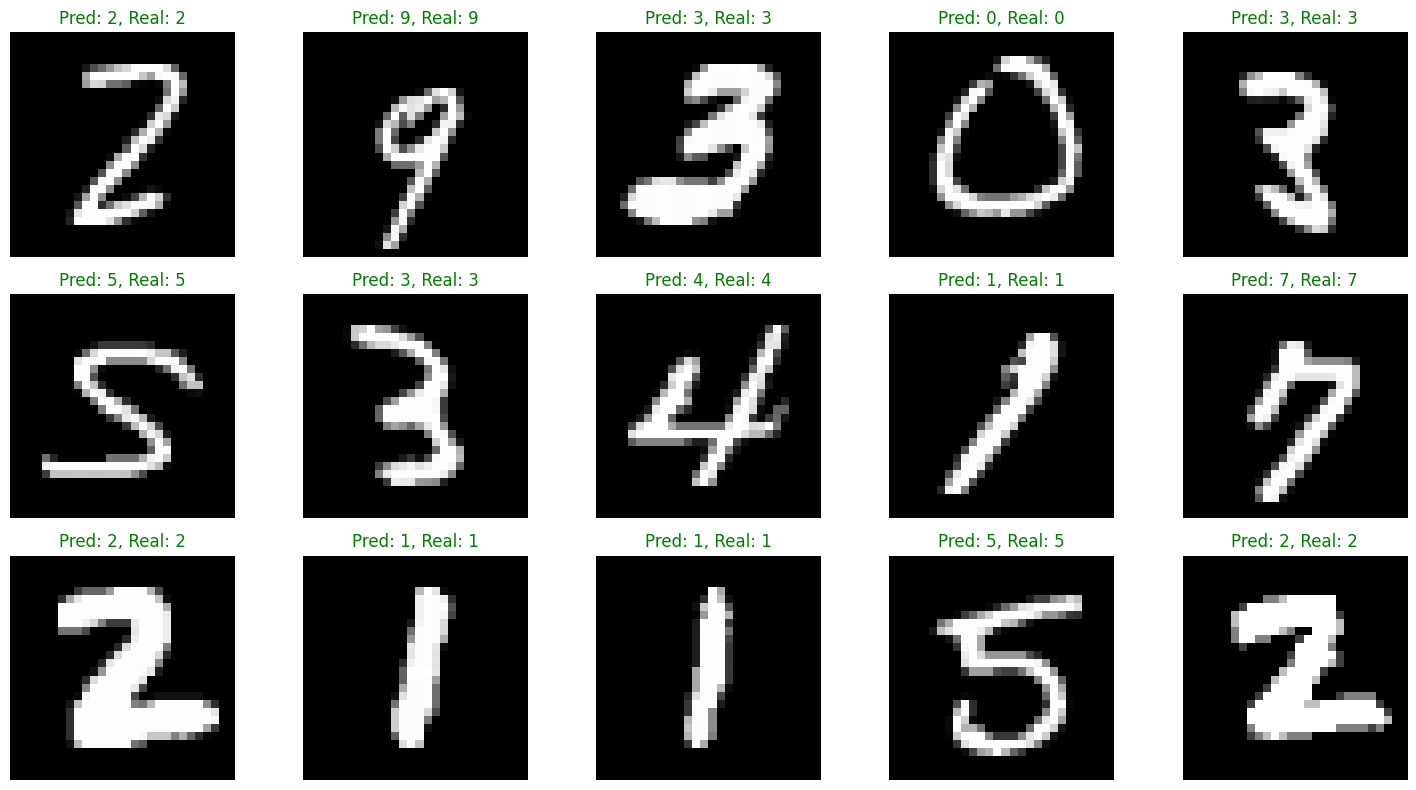

In [15]:
# Visualizar algunas predicciones
n_samples = 15
indices = np.random.choice(len(x_test), n_samples, replace=False)

plt.figure(figsize=(15, 8))
for i, idx in enumerate(indices):
    plt.subplot(3, 5, i + 1)
    plt.imshow(x_test[idx].reshape(28, 28), cmap='gray')
    pred = y_pred[idx]
    actual = y_test[idx]
    plt.title(f"Pred: {pred}, Real: {actual}", color=('green' if pred == actual else 'red'))
    plt.axis('off')

plt.tight_layout()
plt.show()

## 9. Guardado de imágenes para pruebas de API

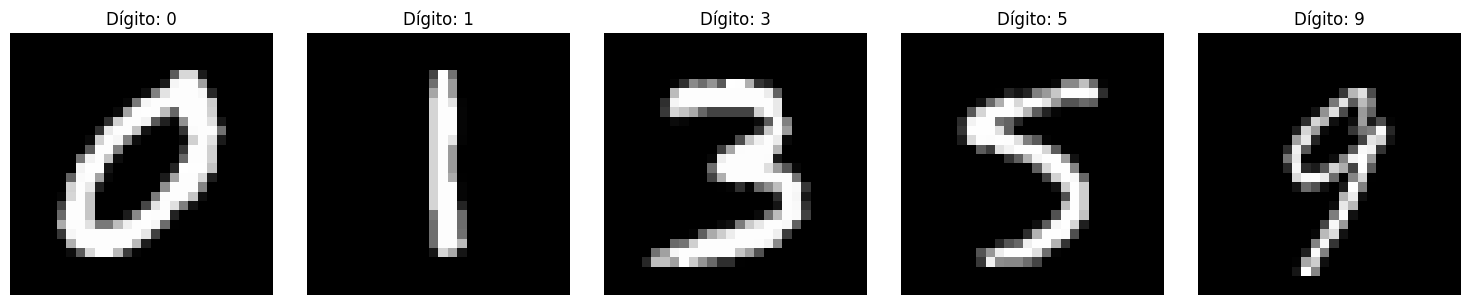

Se han guardado 5 imágenes en el directorio 'test_images'


In [16]:
# Guardar algunas imágenes para pruebas posteriores con la API

# Crear directorio si no existe
os.makedirs('test_images', exist_ok=True)

# Guardar 5 imágenes de prueba (una de cada clase diferente)
selected_digits = [0, 1, 3, 5, 9]  # Seleccionamos algunos dígitos diferentes
test_images = []

for digit in selected_digits:
    # Encontrar ejemplos del dígito en el conjunto de prueba
    digit_indices = np.where(y_test == digit)[0]
    if len(digit_indices) > 0:
        selected_idx = np.random.choice(digit_indices)
        image = x_test[selected_idx].reshape(28, 28)
        
        # Guardar imagen
        plt.imsave(f'test_images/digit_{digit}.png', image, cmap='gray')
        test_images.append((selected_idx, digit))

# Mostrar las imágenes guardadas
plt.figure(figsize=(15, 3))
for i, (idx, digit) in enumerate(test_images):
    plt.subplot(1, len(test_images), i+1)
    plt.imshow(x_test[idx].reshape(28, 28), cmap='gray')
    plt.title(f"Dígito: {digit}")
    plt.axis('off')

plt.tight_layout()
plt.show()

print(f"Se han guardado {len(test_images)} imágenes en el directorio 'test_images'")

## 10. Guardado del modelo para la API

In [17]:
# Guardar el modelo para usarlo posteriormente en la API
model.save('mnist_model.h5')
print("Modelo guardado como 'mnist_model.h5'")

# # Guardar el modelo para usarlo posteriormente en la API
# model.save('mnist_model.keras')
# print("Modelo guardado como 'mnist_model.keras'")

Modelo guardado como 'mnist_model.h5'
